# Classification

In [1]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# to plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
%matplotlib inline

## 1 MNIST

+ a set of 70000 small images of digits handwritten
+ each image has 784 features, because each image is 28x28 pixels(像素), and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black)
+ each image is labeled with the digit it represent


Fetches the MNIST dataset:

In [2]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

**Datasets loaded by Scikit-Learn** generally have a similar dictionary structure including:
+ a **DESCR** key describing the dataset
+ a **data** key containing an array with one row per instance and one column per feature
+ a **target** key containing an array with the labels

Look at these arrays:

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape, "\t", y.shape)

(70000, 784) 	 (70000,)


In [4]:
print("The type of X:\t", type(X))
print("The type of y:\t", type(y))

The type of X:	 <class 'numpy.ndarray'>
The type of y:	 <class 'numpy.ndarray'>


Take a peek at on digit from the dataset: 
1. grab an instances's feature vector
2. reshape it to a 28x28 array
3. and display it using Matplotlib's `imshow()` func:

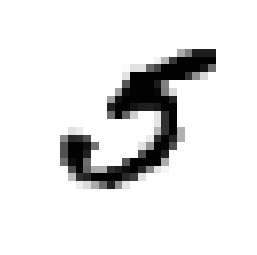

In [5]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[36000]

5.0

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

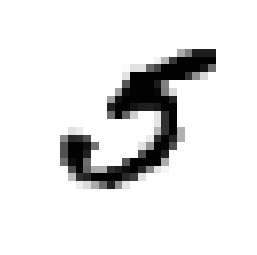

In [8]:
plot_digit(X[36000])

<font color='red'>U should always create a test set and set it aside before inspecting the data closely.</font>

The MNIST dataset is actually already split into a training set (the first 60000 images) and a test set (the last 10000 images).

In [9]:
y[:60000]

array([0., 0., 0., ..., 9., 9., 9.])

In [10]:
y[60000:]

array([0., 0., 0., ..., 9., 9., 9.])

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Shuffle the training set; this will guarantee that all cross-validation folds will be similar (u don't want one fold to be missing some digits).

In [12]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 2 Training a Binary Classifier

Simplify the problem for now and only try to identify one digit (the number 5). This "5-detector" will be an example of a <font color='red'>**binary classifier**</font>, capable of distinguishing between just two classes, 5 and not-5.

Create the target vectors for this classification task:

In [13]:
# True fo all 5s, False for all other digits
y_train_5 = (y_train == 5)
y_train_5

array([False, False, False, ..., False, False, False])

In [14]:
y_test_5 = (y_test == 5)

Start with a <font color='red'>**Stochastic Gradient Descent (SGD)**</font> (having a advantage of being capable of handling very large datsets efficiently).

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

#### Measuring Accuracy Using Cross-Validation

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9502 , 0.96565, 0.96495])

The following codes does roughly the same thing as the `cross_val_score()` code, and prints the same result:

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


> Above 95% *accuracy* (ratio of correct predictions) on all cv folds.

Get a very dumb classifier that just classfies every imae in the 'not-5' class (只是简单地把所有image分为'not-5'):

In [19]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype= bool)

In [20]:
never_t_clf = Never5Classifier()
cross_val_score(never_t_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

> It has over 90% accuracy. This is because only about 10% of the image are 5s, so i u always guess that an image is not a 5, u will be right about 90% of the time.

This demonstrates why **accuracy is generally not the preferred performance measure for classifier**. especially when u are dealing with *skewed datasets* (i.e. when some classes are much more frequent than others).

### Confusion Matrix (混淆矩阵)

A much better way to evaluate the performance of a classifier is to look at the **confusion matrix**. The general idea is to count the number of times instances of class A are classified as class B.

To compute the confusion matrix, u first need to have a set of predictions, so they can be compared to the actual targets. Use the `cross_val_predict()`.

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [22]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

In [23]:
np.unique(y_train_5, return_counts=True)

(array([False,  True]), array([54579,  5421], dtype=int64))

In [24]:
# A perfect predictions
y_train_perfect_prd = y_train_5
confusion_matrix(y_train_5, y_train_perfect_prd)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall

+ <font color='red'>Precision</font>: the accuracy of the positive predictions

$$Precision=\frac {TP}{TP+FP}$$

+ <font color='red'>Recall (sensitivity or true positive rate)</font>: the ratio of positive instances that are correctly detected by the clf

$$Recall = \frac {TP}{TP+FN}$$


In [25]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

In [26]:
from sklearn.metrics import precision_score, recall_score

In [27]:
print("Precision:\t", precision_score(y_train_5, y_train_pred))

Precision:	 0.7687135020350381


In [28]:
4344 / (1307 + 4344)

0.7687135020350381

In [29]:
print("Recall:\t", recall_score(y_train_5, y_train_pred))

Recall:	 0.801328168234643


In [30]:
4344 / (1077 + 4344)

0.801328168234643

It is often convenient to combine precision and recall into a single metric call the <font color='red'>$F_1 \quad score$</font>, in particular if u need a simple way to compare two classifier. <font color='red'>$F_1 \quad score$</font> is the *harmonic mean(调和平均数)* of precision and recall.

$$F_1 = \frac {2}{\frac {1}{precision} + \frac {1}{recall}} = 2 \times {\frac {precision \times recall}{precision+recall}} = \frac {TP}{TP+\frac {FN+FP}{2}}$$

In [31]:
from sklearn.metrics import f1_score

In [32]:
f1_score(y_train_5, y_train_pred)

0.7846820809248555

Scikit-Learn gives u access to the decision scores that it uses to make predictions.

`decision_function()` method returns a score for each instance, and then make predictions based on those scores using any threshold u want:

In [33]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([161855.74572176])

In [34]:
threshold = 0

In [35]:
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

In [36]:
threshold = 20000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

> This confirms that raising the threshold decrease recall.

+ **the first way to select a good precision/recall tradeoff**

To plot precision and recall versus the decision threshold.

<font color='red'>**How to decide which threshold to use?**</font>

1. Need to get the scores of all instances in the training set using the `cross_val_predict()` func, specifying that u want it to return decision scores instead of predictions(pass "decision_function" rather than the default "predict" to the argument method);
2. Now with these scores u can compute precision and recall for all possible thresholds using the `precision_recall_curve()` func;
3. Plot precision and recall as functions of the threshold values.

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1,
                             method="decision_function")

In [38]:
y_scores

array([ -434076.49813641, -1825667.15281624,  -767086.76186905, ...,
        -867191.25267994,  -565357.11420164,  -366599.16018198])

In [39]:
from sklearn.metrics import precision_recall_curve

In [40]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [41]:
precisions

array([0.09080706, 0.09079183, 0.09079335, ..., 1.        , 1.        ,
       1.        ])

In [42]:
recalls

array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

In [43]:
thresholds

array([-1613405.71147769, -1612415.64410228, -1611701.37464018, ...,
         954170.04762499,   987947.69103863,  1002862.09359785])

In [44]:
print("length of 'precisions':\t", len(precisions))
print("length of 'recalls':\t", len(recalls))
print("length of 'thresholds':\t", len(thresholds))

length of 'precisions':	 59699
length of 'recalls':	 59699
length of 'thresholds':	 59698


> 长度的关系。

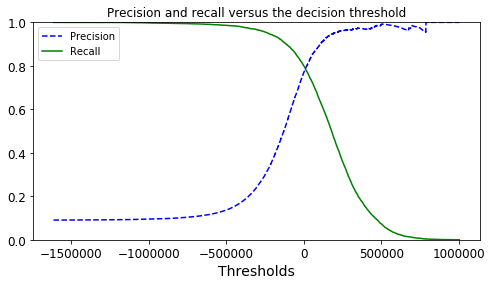

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Thresholds")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("Precision and recall versus the decision threshold")
plt.show()

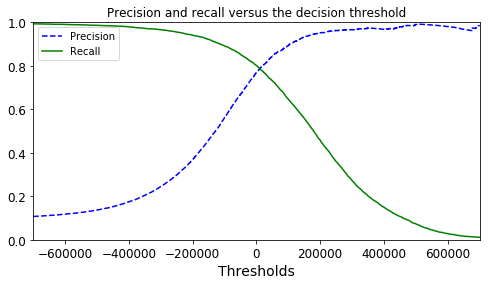

In [46]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Thresholds")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.title("Precision and recall versus the decision threshold")
plt.show()

+ **the second way to select a good precision/recall tradeoff**

To plot precision directly against recall.

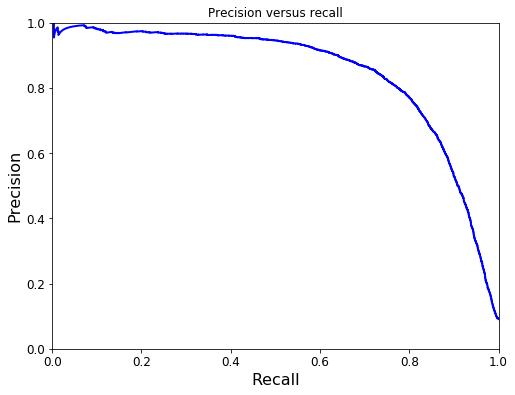

In [47]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])


plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title("Precision versus recall")
plt.show()

> How to select a precision/recall tradeoff depends on your project.

Decide to aim for 90% precision:

In [48]:
y_train_pred_90 = (y_scores > 70000)
y_train_pred_90

array([False, False, False, ..., False, False, False])

Check these predictions' precision and recall:

In [49]:
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [50]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

A high-precision classifier is not very useful if its recall is too low!

If someone says "let's reach 99% precision," u should ask, "at what recall?"

### The ROC Curve

<font color='red'>ROC (receiver operating characteristic)</font> curve is another common tool **used with binary classifiers**.

The ROC curve plots the **true positive rate** (anoter name for **recall**) against the **false positive rate (FPR)**. The FPR is the ratio of negative instances that are incorrectly classified as positive. It equals to one minus the **true negative rate (TNR)**, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called **specificity**. Hence the ROC curve plots **sensitivity (recall)** versus **1 - specificity**.

In [51]:
from sklearn.metrics import roc_curve

In [52]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1,
                             method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [53]:
fpr

array([0.00000000e+00, 0.00000000e+00, 1.83220653e-05, ...,
       9.94466736e-01, 9.94466736e-01, 1.00000000e+00])

In [54]:
thresholds

array([ 1002862.09359785,   788024.40783823,   786459.71073829, ...,
       -1612415.64410228, -1613405.71147769, -2922518.84137436])

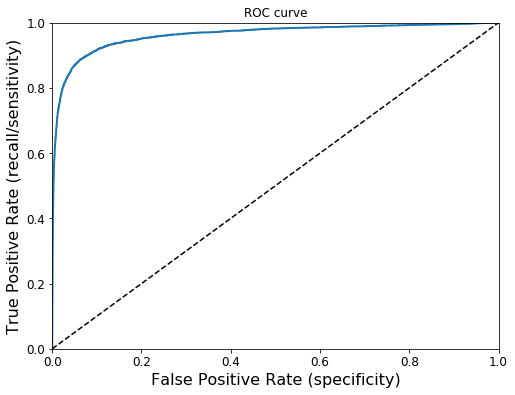

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate (specificity)", fontsize=16)
    plt.ylabel("True Positive Rate (recall/sensitivity)", fontsize=16)


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title("ROC curve")
plt.show()

There is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

<font color='red'>One way to compare classifiers is to measue the **area under the curve (AUC)**</font>. A perfect classifier will have a ROC AUC equals to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [56]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967155

The PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

**Train a RandomForestClassifier**

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    n_jobs=-1, method="predict_proba")
y_probas_forest

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [59]:
y_probas_forest.shape

(60000, 2)

In [60]:
# Use the positive class's probability as the score
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
y_scores_forest

array([0. , 0.1, 0. , ..., 0. , 0. , 0. ])

In [61]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_train_5, y_scores_forest)

In [62]:
fpr_forest.shape

(11,)

In [63]:
tpr_forest.shape

(11,)

In [64]:
thresholds_forest

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

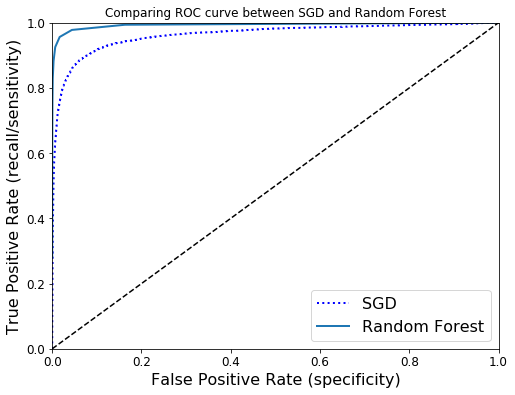

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right",fontsize=16)
plt.title("Comparing ROC curve between SGD and Random Forest")
plt.show()

In [66]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [67]:
# Precision
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [68]:
# Recall
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

## 3 Multiclass Classification

Perform multiclass classification using multiple binary classifiers:
1. one-versus-all (OvA) or one-versus-the-rest
2. one-versus-one (OvO) 

**Scikit-Learn detects when u try to use a binary classfication algorithms for a multi-class classification task, and it automatically runs OvA (except for SVM classifiers for which it use OvO).**

In [69]:
sgd_clf.fit(X_train, y_train)  # OvA
sgd_clf.predict([some_digit])  # expect a 2D array

array([5.])

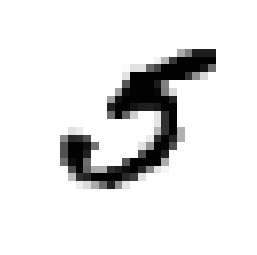

In [70]:
some_digit = X[36000]
plot_digit(some_digit)

In [71]:
some_digit.shape

(784,)

Under the hood, Scikit-Learn actually trained 10 binary classifier, got their decision scores for the image, and selected the class with the highest score.

In [72]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [73]:
# the index of highest score
np.argmax(some_digit_scores)

5

In [74]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [75]:
sgd_clf.classes_[5]

5.0

if u want to force Scikit-Learn to use one-versus-one or one-versus-all, u can use the `OneVsOneClassifier` or `OneVsRestClassifier`. Simply create an instance and pass a binary classifier to its constructor.

In [76]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42),
                             n_jobs=-1)
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [77]:
ovo_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [78]:
# Estimators used for predictions
# ovo_clf.estimators_
len(ovo_clf.estimators_)

45

**Train a Random Forest Classifier:**

In [79]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

Random Forest classifiers can directly classify instances into multiple classes. Call `predict_proba()` to get the list of probabilities that the classifier assigned to each instance for each class:

In [80]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [81]:
forest_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

> 80% probability that the image represents a 5. It also thinks that the image could instead be a 0 or 3 (10% chance each).

**Evaluate these classifiers**:

In [82]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train,
                cv=3, scoring="accuracy", n_jobs=-1)

array([0.91011798, 0.90874544, 0.906636  ])

## Error Analysis

Assume that u have found a promising model and u want to find ways to improve it. One way to do this is to analyze the types of errors it make.

**Look at the confusion matrix:**

In [96]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
y_train_pred

array([1., 6., 6., ..., 0., 2., 9.])

In [97]:
y_train

array([1., 6., 6., ..., 0., 2., 9.])

In [98]:
len(y_train)

60000

In [99]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

Look at an image representation of the confusion matrix, using Matplotlib's `plt.matshow()` func:

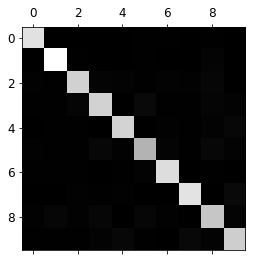

In [100]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

This confusion matrix looks fairly good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the others, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. Both are the case.

In [101]:
conf_mx.sum(1)

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
      dtype=int64)

In [102]:
conf_mx.sum(1, keepdims=True)

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

In [103]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.66570994e-01, 5.06500084e-04, 4.05200068e-03, 1.51950025e-03,
        1.68833361e-03, 8.27283471e-03, 8.44166807e-03, 1.68833361e-03,
        6.58450110e-03, 6.75333446e-04],
       [2.96647879e-04, 9.63067339e-01, 6.37792940e-03, 3.70809849e-03,
        1.03826758e-03, 5.93295758e-03, 7.41619697e-04, 1.48323939e-03,
        1.61673094e-02, 1.18659152e-03],
       [8.55991944e-03, 6.88150386e-03, 8.93084928e-01, 1.74555220e-02,
        1.49378986e-02, 4.36388050e-03, 1.46022155e-02, 1.00704935e-02,
        2.78616986e-02, 2.18194025e-03],
       [7.66595988e-03, 7.50285435e-03, 2.29978796e-02, 8.71309737e-01,
        1.63105529e-04, 3.76773773e-02, 6.52422117e-03, 8.15527646e-03,
        2.29978796e-02, 1.50057087e-02],
       [3.25231085e-03, 4.96405341e-03, 7.01814447e-03, 1.71174255e-03,
        9.18521054e-01, 1.54056830e-03, 9.58575830e-03, 6.33344745e-03,
        1.47209860e-02, 3.23519343e-02],
       [1.34661502e-02, 8.30105147e-03, 6.64084117e-03, 3.56022874e-02,
   

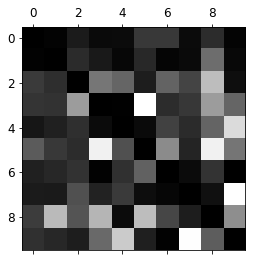

In [104]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows represent actual classes, while columns represent predicted classes.

Analyzing individual errors can also be a good way to gain insights.

In [105]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=matplotlib.cm.binary, **options)
    plt.axis("off")

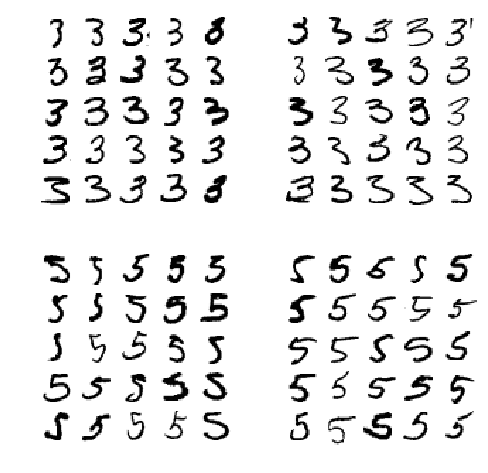

In [106]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

上面两个真实为3， 下面两个真实为5， 左边两个预测为3， 右边两个预测为5.

## Multilabel Classification

In some case, I want my classifier to **output multiple classes for each instances.**

**Create a y_multilabel array containing two target labels for each digit image.**

In [107]:
# 7, 8, or 9
y_train_large = (y_train >= 7)
# Whether or not it is odd
y_train_odd = (y_train % 2 == 1)
# Contain two target labels for each digit image
y_multilabel = np.c_[y_train_large, y_train_odd]

In [108]:
y_train

array([1., 6., 6., ..., 0., 2., 9.])

In [109]:
y_train.shape

(60000,)

In [110]:
print(y_train_large.shape)
y_train_large

(60000,)


array([False, False, False, ..., False, False,  True])

> 没区别啊，加不加括号。

In [111]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [ True,  True]])

**Create a `KNeighborsClassifier` instance which support multilabel classification, but not all classifiers do.**

In [112]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [113]:
knn_clf.predict([some_digit])

array([[False,  True]])

Compute the average $F_1$ score across all labels:

In [114]:
from sklearn.metrics import f1_score

In [115]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel,
                                    cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525

## Multioutput Classification

**Multioutput-multiclass classification** (or simply **multioutput classification**) is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

In [116]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

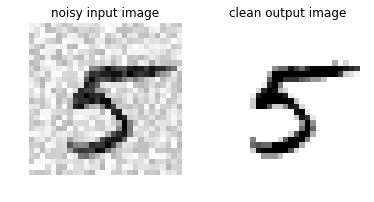

In [118]:
some_index = 5500
plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.title("noisy input image")
plt.subplot(122)
plot_digit(y_test_mod[some_index])
plt.title("clean output image")
plt.show()

Train a classifier and make it clean this image:

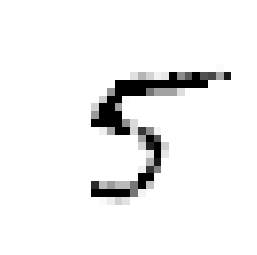

In [119]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)